In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm_notebook
import gym
import gc
import time
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import random

SEED = 33
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

'''
Сеть прямого распостранения, для которой можно задать произвольное число слоев
и нейронов в них:
'''

class FFNet(nn.Module):
    
    def __init__(self, structure):
        
        super().__init__()
        self.arch = nn.ModuleList()
        for i in range(len(structure) - 1):
            self.arch.add_module(f'linear{i}', nn.Linear(structure[i], structure[i+1]))
            if i != (len(structure) - 2):
                self.arch.add_module(f'relu{i}', nn.ReLU())
            
    def forward(self, x):
        for layer in self.arch:
            x = layer(x)
        return x
    
'''
Модификация награды:
'''
    
def mod_reward(reward, gamma, state, new_state, rew_mult): 
    #fterm = (0, 10)[int(state[0] >= 0.5)]
    #n_fterm = (0, 10)[int(new_state[0] >= 0.5)]
    addition = gamma * (abs(new_state[1])) -\
                        (abs(state[1]))
    return reward + rew_mult * addition

'''
Replay buffer:
'''
class Buffer:
    
    def __init__(self, cap):
        from collections import deque
        self.cap = cap
        self.storage = deque(maxlen=self.cap)
        
    def enqueue(self, element):
        self.storage.append(element)

    def sample(self, n):
        return list(zip(*random.sample(self.storage, n)))
    
    def pre_train(self, env, N):
        for i in range(N):
            state = env.reset()
            action = env.action_space.sample()
            ns, rew, done, _ = env.step(action)
            rew = mod_reward(rew, gamma, state, ns, REW_MULT)
            self.enqueue((state, action, ns, rew, done))

'''
Функции для обновления target сетей, использование soft update очень помогло
со сходимостью алгоритма
'''
def soft_update(QNET, TARGET_NET, tau):
    for curr_layer, target_layer in zip(QNET.parameters(), TARGET_NET.parameters()):
        target_layer.data.copy_(tau * curr_layer + (1 - tau) * target_layer)
        
def hard_update(QNET, TARGET_NET):
    for curr_layer, target_layer in zip(QNET.parameters(), TARGET_NET.parameters()):
        target_layer.data.copy_(curr_layer)
'''
Формирование таргета, используется алгоритм double DQN
'''
def get_target(QNET, TARGET_NET, state, action, ns, rew, done):
    
    state = torch.tensor(state).type('torch.FloatTensor')
    new_state = torch.tensor(ns).type('torch.FloatTensor')
    rew = torch.tensor(rew).type('torch.FloatTensor').view(-1, 1)
    action = torch.tensor(action).view(-1, 1)
    done = torch.tensor(done).view(-1, 1)
    
    Q = QNET(state)
    
    with torch.no_grad():
        next_action = torch.argmax(QNET(new_state), 1).view(-1, 1)
        Q2 = TARGET_NET(new_state)
    
    target_term = torch.gather(Q2, 1, next_action)
    target_term[done] = 0
    target = rew + gamma * target_term
    Q = torch.gather(Q, 1, action)
    return Q, target
'''
Функция для тестирования сети и для визуализации
'''
def test_plot(env, QNET, n_epochs, plot=False):
    
    rewards = np.zeros(n_epochs)
    final_pos = np.zeros(n_epochs)
    n_steps = np.zeros(n_epochs)
    
    for i in range(n_epochs):
        state = env.reset()
        curr_reward = 0
        for j in range(200):
            with torch.no_grad():
                Q = QNET(torch.tensor(state).type('torch.FloatTensor'))
                action = torch.argmax(Q).item()
            state, reward, done, info = env.step(action)
            curr_reward += reward
            if done:
                break
        rewards[i] = curr_reward
        final_pos[i] = state[0]
        n_steps[i] = j
                
    if plot:
        fig, axarr = plt.subplots(1, 3, figsize=[20, 10])
        fig.suptitle(f'Performance test over {n_epochs} iterations')

        axarr[0].hist(rewards, label=f'Mean reward = {round(np.mean(rewards), 3)}')
        axarr[0].set_title('Reward per episode')

        axarr[1].hist(final_pos, label = f'Successful episodes = {sum(final_pos >= 0.5)/n_epochs * 100} %')
        axarr[1].set_title('Position at the end of an episode')

        axarr[2].hist(n_steps[final_pos >= 0.5], label = f'Mean = {np.mean(n_steps[final_pos>=0.5])}')
        axarr[2].set_title('Number of iterations it took \n to succed')

        for ax in axarr:
            ax.legend()
            ax.grid()
        
    return rewards, final_pos, n_steps

In [2]:
gc.collect()

7

In [3]:
# Я поменял с MODEL11 на MODEL12, чтобы нечаянно не перезаписать папку)
SAVEPATH = 'models/MODEL12/DQN_discrete11' 

In [4]:
env = gym.make('MountainCar-v0')
env.seed(SEED)
env.reset()

array([-0.57840555,  0.        ])

In [5]:
#RL hyperparameters
n_epochs = int(7e3)
steps_per_ep = 200
tau = 1e-3

gamma = 0.99

start_eps = 1
end_eps = 1e-2
decay = 0.5e-3

REW_MULT = 600

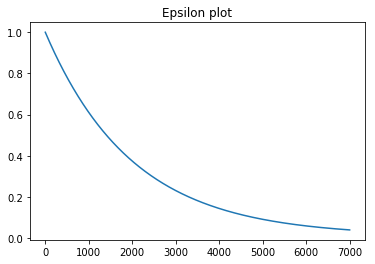

In [6]:
plt.plot([end_eps + (start_eps - end_eps) * np.exp(-decay * i) for i in range(n_epochs)])
_ = plt.title('Epsilon plot')

In [7]:
#Net hyperparamteters
QNET = FFNet([env.observation_space.shape[0],
             64,
             32,
             3])

TARGET_NET = FFNet([env.observation_space.shape[0],
             64,
             32,
             3])

hard_update(QNET, TARGET_NET)

start_alpha = 1e-3
min_alpha = 5e-5
#alpha_decay = 0.995
opt = torch.optim.Adam(QNET.parameters(), lr=start_alpha)
decay_func = lambda epoch: (n_epochs - epoch)/n_epochs
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, decay_func, last_epoch=-1)

loss_fn = nn.MSELoss()
batch_size = 256

Dataholder = Buffer(8000)
Dataholder.pre_train(env, batch_size)

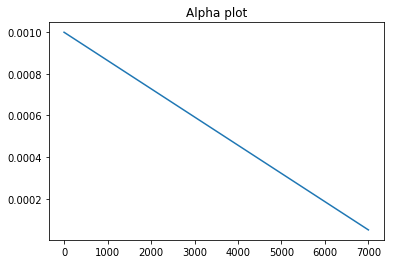

In [8]:
plt.plot([start_alpha - (start_alpha - min_alpha) * i/n_epochs for i in range(n_epochs)])
_ = plt.title('Alpha plot')

In [9]:
max_pos = np.NINF
fpos_ = []
rewards = []
rewards_ = []
n_steps = []
successes = []
curr_eps = start_eps
glob_step = 0

t_rewards = []
t_succ = []
t_fpos = []


for i in tqdm_notebook(range(n_epochs)):
    
    if ((i % 100) == 0):
        rew, succ, fpos = [np.mean(x) for x in test_plot(env, QNET, 500, plot=False)]
        t_rewards.append(rew)
        t_succ.append(succ)
        t_fpos.append(fpos)
        torch.save(QNET.state_dict(), SAVEPATH+f'_{i%100}_{rew}_{succ}_{fpos}')
        
    curr_reward = 0
    curr_reward_ = 0
    
    if ((i % 100) == 0) and (i != 0):
        mean_rew_ = np.mean(rewards_[i-100:i])
        mean_rew = np.mean(rewards[i-100:i])
        print(f'Iteration {i}: reward_ = {mean_rew_}, max_pos = {max_pos}, reward = {mean_rew}')
        max_pos = np.NINF
        
    state = env.reset()
    for j in range(steps_per_ep):  
        
        if np.random.rand() < curr_eps:
            action = np.random.randint(0, 3)
        else:
            with torch.no_grad():
                Q = QNET(torch.tensor(state).type('torch.FloatTensor'))
                action = torch.argmax(Q).item()
            
        new_state, reward, done, info = env.step(action)
        
        reward_ = mod_reward(reward, gamma, state, new_state, REW_MULT)
        
        Dataholder.enqueue((state, action, new_state, reward_, done))
        
        Q, target = get_target(QNET, TARGET_NET, *Dataholder.sample(batch_size))
        
        opt.zero_grad()
        loss_val = loss_fn(Q, target)
        loss_val.backward()
        opt.step()
        
        soft_update(QNET, TARGET_NET, tau)
        
        curr_reward += reward
        curr_reward_ += reward_
        state = new_state
        
        if state[0] > max_pos:
            max_pos = state[0]
            
        if state[0] > 0.5:
            scheduler.step()
        
        if done:
            break
    
    curr_eps = end_eps + (start_eps - end_eps) * np.exp(-decay * i)
    rewards.append(curr_reward)
    rewards_.append(curr_reward_)
    fpos_.append(state[0])
    n_steps.append(j)
    
    gc.collect()
    
torch.save(QNET.state_dict(), SAVEPATH)

Iteration 100: reward_ = -201.80658754450857, max_pos = -0.21875324846089123, reward = -200.0
Iteration 200: reward_ = -201.30725944993435, max_pos = -0.18435235104605918, reward = -200.0
Iteration 300: reward_ = -201.8948233665932, max_pos = -0.14860099199082427, reward = -200.0
Iteration 400: reward_ = -202.064523472228, max_pos = -0.0840156801778931, reward = -200.0
Iteration 500: reward_ = -202.24961715807697, max_pos = 0.050741794564155764, reward = -200.0
Iteration 600: reward_ = -201.6633774186657, max_pos = 0.07379035778270678, reward = -200.0
Iteration 700: reward_ = -203.9753702236136, max_pos = 0.25408302618536777, reward = -200.0
Iteration 800: reward_ = -201.53359433501555, max_pos = 0.17546846932673477, reward = -200.0
Iteration 900: reward_ = -203.4541460531955, max_pos = 0.24106736591065916, reward = -200.0
Iteration 1000: reward_ = -206.7760169817379, max_pos = 0.3602744894682726, reward = -200.0
Iteration 1100: reward_ = -205.43086331687323, max_pos = 0.34055610411507

Как видно, существует проблема со схождением алгоритма, но каждые 100 итераций я сохранял сеть, в названии файла записывал среднюю награду на тесте.

Положительное влияние на сходимость оказала техника polyak averaging для target сети, а также создание линейного scheduler для шага обучения нейронной сети.

Text(0.5,1,'Mean test rewards')

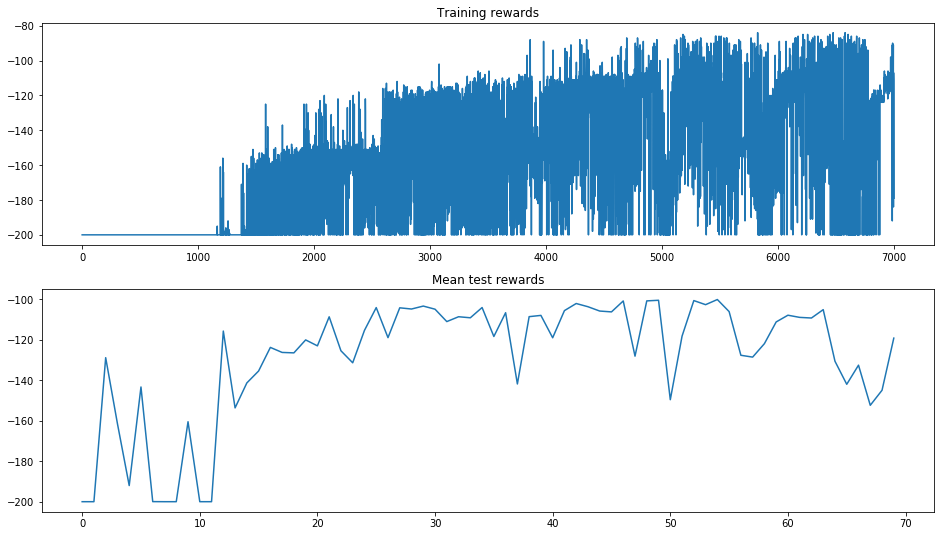

In [13]:
fig, axarr = plt.subplots(2, 1, figsize = [16, 9])
axarr[0].plot(rewards)
axarr[0].set_title('Training rewards')
axarr[1].plot(t_rewards)
axarr[1].set_title('Mean test rewards')

Найдем лучшую сеть:

In [17]:
from os import listdir
model_list = listdir(SAVEPATH[:-SAVEPATH[::-1].find('/')])

In [22]:
model_list[:10]

['DQN_discrete11',
 'DQN_discrete11_0_-100.232_0.5150155312166678_99.232',
 'DQN_discrete11_0_-100.598_0.5149357083083721_99.598',
 'DQN_discrete11_0_-100.75_0.5118687907495441_99.75',
 'DQN_discrete11_0_-100.904_0.515650944511636_99.904',
 'DQN_discrete11_0_-100.936_0.5117775681225656_99.936',
 'DQN_discrete11_0_-102.202_0.5154325544876913_101.202',
 'DQN_discrete11_0_-102.772_0.5106716191472915_101.772',
 'DQN_discrete11_0_-103.462_0.5181423942913095_102.462',
 'DQN_discrete11_0_-103.786_0.5161639668543576_102.786']

Можно убедиться, что список уже отсортирован по качеству моделей, кроме самой первой, это последняя версия сети.

In [23]:
TEST_NET = FFNet([env.observation_space.shape[0],
             64,
             32,
             3])
s_dict = torch.load(SAVEPATH[:-SAVEPATH[::-1].find('/')] + model_list[1])
TEST_NET.load_state_dict(s_dict)

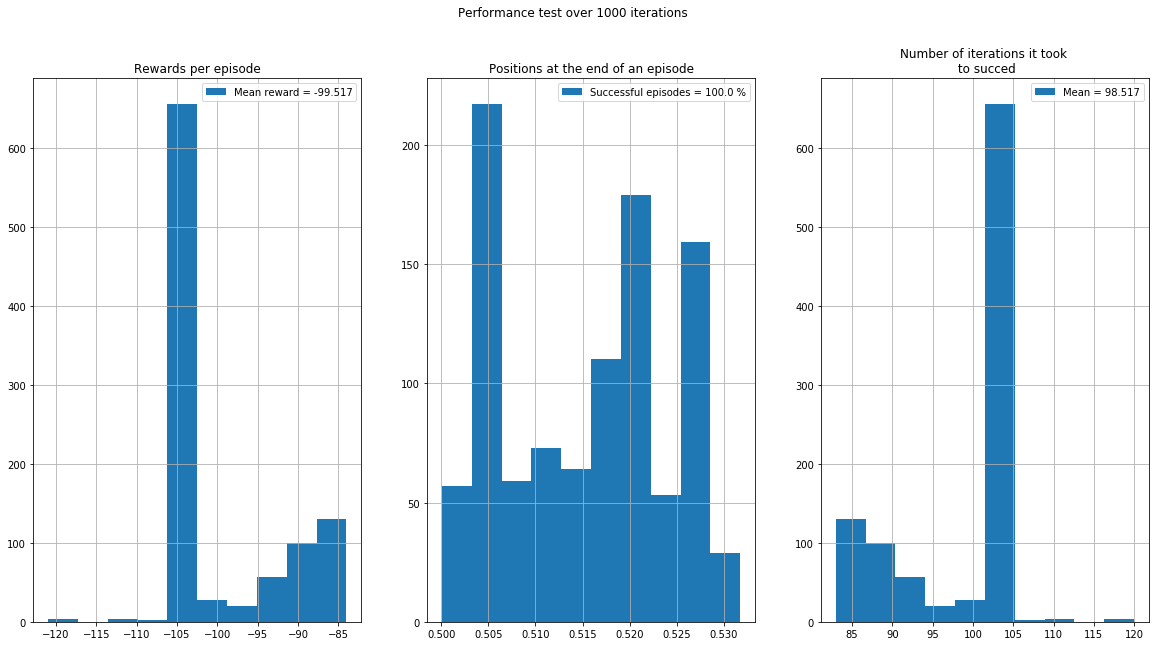

In [26]:
_ = test_plot(env, TEST_NET, 1000, plot=True)

На всякий случай протестируем и последнюю версию сети, для которой не записали в файл значения качества:

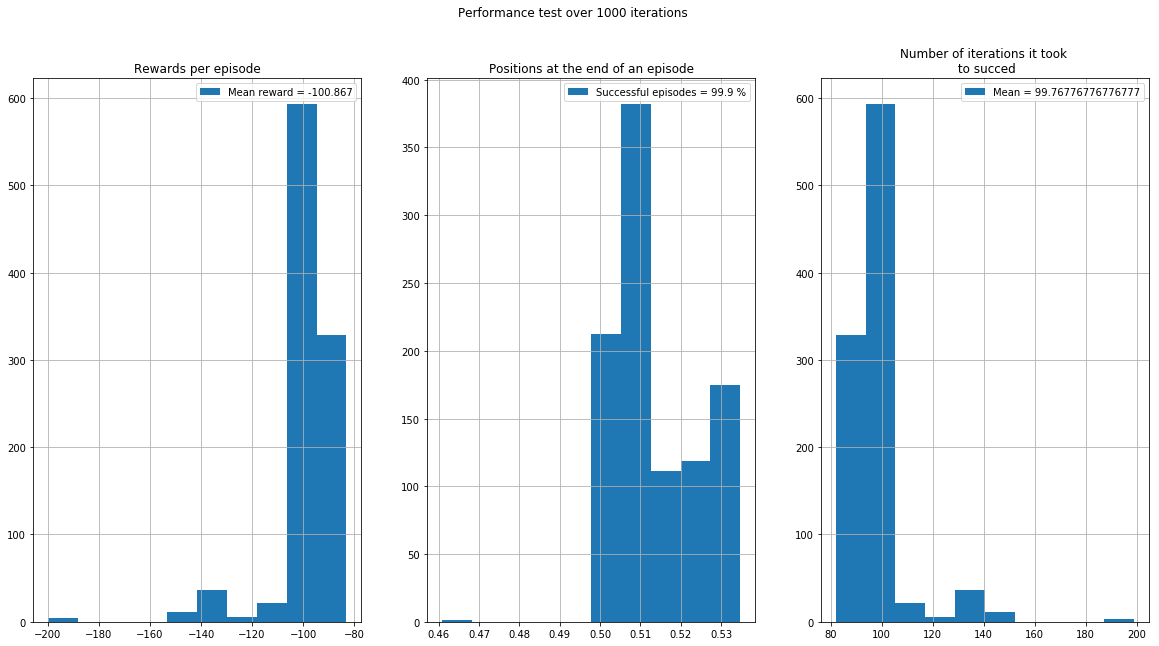

In [32]:
_ = test_plot(env, QNET, 1000, plot=True)

Кажется, мода и медиана оказались даже лучше, но все же графики лежат в разных пределах.

Можно визуализировать поведение агента:

In [37]:
state = env.reset()
total_reward = 0
for i in range(200):
    Q = QNET(torch.tensor(state).type('torch.FloatTensor'))
    action = torch.argmax(Q).item()
    
    new_state, reward, done, _ = env.step(action)
    total_reward += mod_reward(reward, gamma, state, new_state, REW_MULT)
    env.render()
    time.sleep(0.05)
    state = new_state
    if done:
        print("Ending state:", state)
        print("Steps:", i)
        print("Reward:", total_reward)
        break
env.close()

Ending state: [0.51806901 0.0211371 ]
Steps: 88
Reward: -87.59909967389616
